In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Running experiment with n-gram range: (1, 1)
Running experiment with n-gram range: (1, 2)
Running experiment with n-gram range: (1, 3)


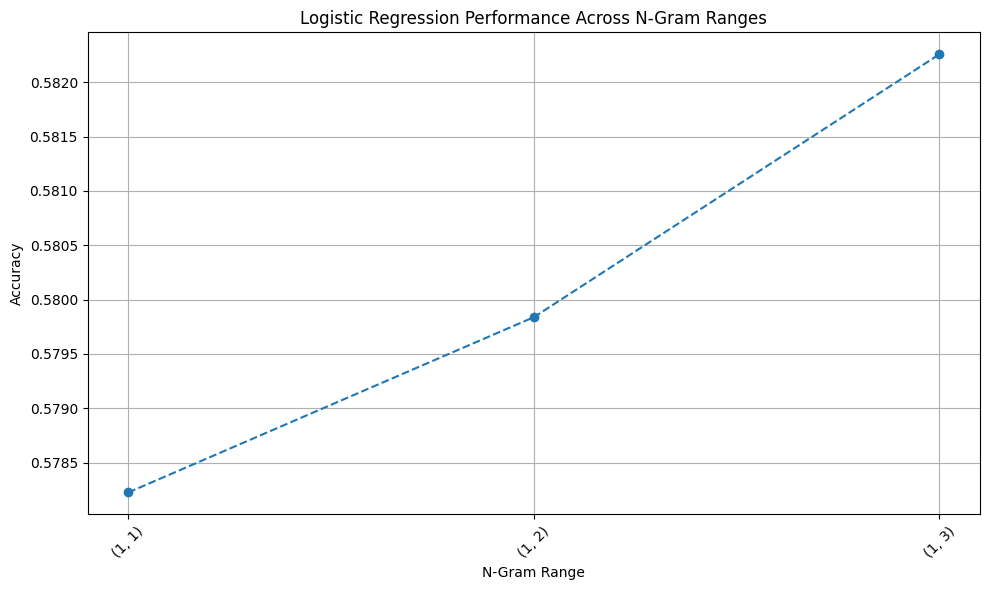

In [27]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
import matplotlib.pyplot as plt

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Data loading
training = pd.read_csv("/content/drive/MyDrive/FALL2024/comp550/final_project/sarcasm/reddit/no_context/training_response.csv")
testing = pd.read_csv("/content/drive/MyDrive/FALL2024/comp550/final_project/sarcasm/reddit/no_context/testing_response.csv")
combined_df = pd.concat([training, testing], axis=0)

# Preprocessing Functions
def clean_text(response):
    stop_words = set(stopwords.words('english'))
    response = re.sub(r'[^a-zA-Z]', ' ', response.lower())  # Lowercase and remove special characters
    words = response.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)

def preprocess_data(data):
    return data['response'].apply(clean_text)

# Bag-of-Words Creation
def create_bag_of_words(corpus, ngram_range=(1, 1), max_features=1600):
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
    return vectorizer.fit_transform(corpus).toarray()

# Model Training and Evaluation
def train_and_evaluate_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)
    model = LogisticRegression(max_iter=200)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    }

# Experiment Runner
def run_experiments(data, labels, ngram_combinations):
    results = []
    for ngram_range in ngram_combinations:
        print(f"Running experiment with n-gram range: {ngram_range}")
        cleaned_corpus = preprocess_data(data)
        X = create_bag_of_words(cleaned_corpus, ngram_range)
        results.append({
            'ngram_range': ngram_range,
            'metrics': train_and_evaluate_models(X, labels)
        })
    return results

# Plot Results
def plot_accuracies(results):
    accuracies = [result['metrics']['accuracy'] for result in results]
    ngram_labels = [str(result['ngram_range']) for result in results]

    plt.figure(figsize=(10, 6))
    plt.plot(ngram_labels, accuracies, marker='o', linestyle='--')
    plt.xlabel('N-Gram Range')
    plt.ylabel('Accuracy')
    plt.title('Logistic Regression Performance Across N-Gram Ranges')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Run the Experiments
ngram_ranges = [(1, 1), (1, 2), (1, 3)]  # Unigram, bigram, trigram combinations
truth_status = combined_df.iloc[:, -1].values
experiment_results = run_experiments(combined_df, truth_status, ngram_ranges)

# Plot
plot_accuracies(experiment_results)